In [1]:
import sys
sys.path.append("../../gaia_tools/")
sys.path.append("../../scripts/")
import covariance_generation as cov
from mcmc_plots import *
import numpy as np
import emcee
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from pylab import *
from scipy.optimize import curve_fit
from cProfile import label
import pandas as pd

In [2]:
from scipy.stats import linregress
def get_curve_slope(vc, R):
    print(vc)
    linear_reg_result = linregress(np.array(R), np.abs(vc))
    return linear_reg_result

In [3]:
# Rotation Curve Plotting Function

def plot_rotation_curve(mcmc_runs, 
                        labels, 
                        burnin, 
                        extra_dims=[], 
                        display_eilers=False, 
                        display_bin_edges=False,
                        is_last_merged=False,
                        ):


    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'red', 'blue', 'green', 'orange']
    

    if(is_last_merged):
        new_bin_center = (bin_centers_r[-2] + bin_centers_r[-1])/2
        bin_centers_r = np.delete(bin_centers_r, -1)
        bin_centers_r[-1] = new_bin_center

    mcmc_fmts = ['o', 'd']
    for i_path, path in enumerate(mcmc_runs):
        bin_setup = load_bin_settings(mcmc_runs[i_path], is_print=False)
        bin_centers_r = bin_setup['bin_centers_r']

        if(i_path > 0):
            bin_centers_r = bin_centers_r/8.277*8.178

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

        bin_velocities = []
        ndim = samples_data.shape[2]

        if(len(extra_dims) > 0):
            ndim = samples_data.shape[2] - extra_dims[i_path]
        
        print('R, v_c, sig-, sig+')
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            v_med = np.median(flatchain[:, i])
            bin_velocities.append((v_med, v_sub, v_sup))

            print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
        velocity_array = np.array(bin_velocities)

        # Get and print curve slope
        print(velocity_array)
        linear_reg_result = get_curve_slope(velocity_array[:,0], bin_centers_r)
        print(linear_reg_result)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = np.linspace(-100, 100, len(mcmc_runs))
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]
        y_error = [velocity_array[:,1], velocity_array[:,2]]

        print(x_values.shape)
        print(y_values.shape)

        
        plt.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt=mcmc_fmts[i_path], 
                    c=colors[i_path], 
                    label=labels[i_path], 
                    markersize = 8)
        
        bin_edges_r = bin_setup['bin_edges'][0][0]
        if(display_bin_edges):
            if(is_last_merged):
                # Remove middle boundary
                bin_edges_r = np.delete(bin_edges_r, -2)

            if(i_path > 0): continue
            ax.vlines(bin_edges_r, 150, 255, linestyles='dashed', alpha=0.5, colors=colors[i_path])   
            #x_ticks = np.round(bin_edges_r)
            #ax.set_xticks(x_ticks)

    plt.xlabel(r'$R$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)


    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    ax.xaxis.set_major_locator(MultipleLocator(2*1e3))
    ax.yaxis.set_major_locator(MultipleLocator(10))

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())


    lit_fmts = ['+', 'x', '^', 'v', '.', '0']
    lit_fmts = ['^', 'v', '.', '+', 'x', 'o']
    lit_colors = ['blue', 'green', 'brown', 'orange', 'grey', 'red']
    lit_colors = ['brown', 'orange', 'grey', 'blue', 'green', 'red']
    if(display_eilers):
        for i, key in enumerate(other_curves_dict.keys()):
            print(key)
            rc_data = other_curves_dict[key]
            rc_data = rc_data[rc_data.R <= 26]

            rc_y_values = np.array(rc_data.v_c)
            rc_x_values = np.array(rc_data.R*1e3)

            print(rc_x_values)
            
            if((key == 'Eilers et al. 2018') or (key == 'Ou et al. 2023')):
                print(key)
                print(rc_data.columns)
                rc_y_error = [np.array(rc_data.sig_below), np.array(rc_data.sig_above)]
            else:
                rc_y_error = [np.array(rc_data.sig), np.array(rc_data.sig)]

            plt.errorbar(rc_x_values, rc_y_values, 
                    yerr=rc_y_error, 
                    fmt=lit_fmts[i],
                    color = lit_colors[i],
                    label=key, alpha=0.6)

    plt.legend(prop={'size': 9}, ncol=2, columnspacing=3)

    #h_lines  = np.arange(210, 251, 10)
    #ax.hlines(h_lines, 4500, 15500, linestyles='dashed', alpha=0.5, colors='grey')
     
    plt.xlim(4000, 25500)
    plt.rcParams["axes.grid"] = False

    return x_values, velocity_array



def load_bin_settings(folder_path, is_print=False):
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        data = handle.read()
    bin_setup = pickle.loads(data)

    if(is_print):
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))

    return bin_setup

In [83]:
# Rotation Curve Plotting Function

def plot_rotation_curve_delta_unc(mcmc_runs, 
                        labels, 
                        burnin, 
                        extra_dims=[], 
                        display_eilers=False, 
                        display_bin_edges=False,
                        is_last_merged=False,
                        ):

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, axs = plt.subplots(1, 1, figsize=(12, 6), sharey=False, sharex=True)
    divider = make_axes_locatable(axs)
    # Create ratio axes
    ax2 = divider.append_axes("bottom", size='40%', pad=0.15)
    axs.figure.add_axes(ax2)

    # fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'red', 'blue', 'green', 'orange']
    

    if(is_last_merged):
        new_bin_center = (bin_centers_r[-2] + bin_centers_r[-1])/2
        bin_centers_r = np.delete(bin_centers_r, -1)
        bin_centers_r[-1] = new_bin_center

    mcmc_fmts = ['o', 'd']
    for i_path, path in enumerate(mcmc_runs):
        bin_setup = load_bin_settings(mcmc_runs[i_path], is_print=False)
        bin_centers_r = bin_setup['bin_centers_r']

        if(i_path > 0):
            bin_centers_r = bin_centers_r/8.277*8.178

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

        bin_velocities = []
        ndim = samples_data.shape[2]

        if(len(extra_dims) > 0):
            ndim = samples_data.shape[2] - extra_dims[i_path]
        
        print('R, v_c, sig-, sig+')
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            v_med = np.median(flatchain[:, i])
            bin_velocities.append((v_med, v_sub, v_sup))

            print("{} {} {} {}".format(round(bin_centers_r[i]/1e3, 2) ,-round(v_mean,1), round(v_sub,1), round(v_sup, 1)))
        velocity_array = np.array(bin_velocities)

        # Get and print curve slope
        print(velocity_array)
        linear_reg_result = get_curve_slope(velocity_array[:,0], bin_centers_r)
        print(linear_reg_result)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = np.linspace(-100, 100, len(mcmc_runs))
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]
        y_error = [velocity_array[:,1], velocity_array[:,2]]

        print(x_values.shape)
        print(y_values.shape)

        
        axs.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt=mcmc_fmts[i_path], 
                    c=colors[i_path], 
                    label=labels[i_path], 
                    markersize = 8)
        
        bin_edges_r = bin_setup['bin_edges'][0][0]
        if(display_bin_edges):
            if(is_last_merged):
                # Remove middle boundary
                bin_edges_r = np.delete(bin_edges_r, -2)

            if(i_path > 0): continue
            axs.vlines(bin_edges_r, 150, 255, linestyles='dashed', alpha=0.5, colors=colors[i_path])   
            #x_ticks = np.round(bin_edges_r)
            #ax.set_xticks(x_ticks)

    axs.legend()

    ax2.set_xlabel(r'$R$ [kpc]', fontdict={'fontsize' : 16})
    axs.set_ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})

    axs.tick_params(axis='both', which='major', labelsize=10)
    axs.tick_params(axis='both', which='minor', labelsize=8)

    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.tick_params(axis='both', which='minor', labelsize=8)

    ax2.set_xticks([0, 0.025, 0.05])

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax2.xaxis.set_major_formatter(fmt)


    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    axs.set_xticks([])
    ax2.xaxis.set_major_locator(MultipleLocator(2*1e3))
    axs.yaxis.set_major_locator(MultipleLocator(10))

    ax2.xaxis.set_minor_locator(AutoMinorLocator())
    axs.yaxis.set_minor_locator(AutoMinorLocator())



    lit_fmts = ['+', 'x', '^', 'v', '.', '0']
    lit_fmts = ['^', 'v', '.', '+', 'x', 'o']
    lit_colors = ['blue', 'green', 'brown', 'orange', 'grey', 'red']
    lit_colors = ['brown', 'orange', 'grey', 'blue', 'green', 'red']
    if(display_eilers):
        for i, key in enumerate(other_curves_dict.keys()):
            print(key)
            rc_data = other_curves_dict[key]
            rc_data = rc_data[rc_data.R <= 26]

            rc_y_values = np.array(rc_data.v_c)
            rc_x_values = np.array(rc_data.R*1e3)

            print(rc_x_values)
            
            if((key == 'Eilers et al. 2018') or (key == 'Ou et al. 2023')):
                print(key)
                print(rc_data.columns)
                rc_y_error = [np.array(rc_data.sig_below), np.array(rc_data.sig_above)]
            else:
                rc_y_error = [np.array(rc_data.sig), np.array(rc_data.sig)]

            axs.errorbar(rc_x_values, rc_y_values, 
                    yerr=rc_y_error, 
                    fmt=lit_fmts[i],
                    color = lit_colors[i],
                    label=key, alpha=0.6)

    axs.legend(prop={'size': 9}, ncol=2, columnspacing=3)

    #h_lines  = np.arange(210, 251, 10)
    #ax.hlines(h_lines, 4500, 15500, linestyles='dashed', alpha=0.5, colors='grey')
     
    axs.set_xlim(4000, 25500)
    ax2.set_xlim(4000, 25500)
    plt.rcParams["axes.grid"] = False


    # ax2 figure

    Ou_unc_data_path = '/home/sven/repos/gaia-tools/jupyter-notebook/xo_data_nbs/uncertainties_Ou.dat'
    Ou_unc_data = pd.read_csv(Ou_unc_data_path, skiprows=2, names=['R', 'Delta'], delimiter='    ')

    deta_Ou_sample = (velocity_array[:, 1] + velocity_array[:, 2])/np.abs(velocity_array[:,0])

    x_ou = Ou_unc_data.R
    y_ou = Ou_unc_data.Delta

    ax2.plot(x_ou*1e3, y_ou, label='Ou et al.', color='red', alpha=0.6)
    ax2.plot(x_values, deta_Ou_sample, color='black', label='Ou et al. sample (Põder code)')

    ax2.set_ylabel(r'$\Delta_{sys}/V_c$',  fontdict={'fontsize' : 16})
    ax2.legend()
    ax2.set_ylim(0, 0.1)

    return x_values, velocity_array



def load_bin_settings(folder_path, is_print=False):
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        data = handle.read()
    bin_setup = pickle.loads(data)

    if(is_print):
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))

    return bin_setup

## Figure 1: Poder et al. vs Ou et al. sample (Poder code)

In [38]:
# Curves from literature

headers = ['R', 'v_c', 'sig']
cepheids_pm_method = pd.read_csv("../others_curves/cepheids_ablimit_1.dat", sep='  ', names=headers, skiprows=2, engine='python')
cepheids_vel_method = pd.read_csv("../others_curves/cepheids_ablimit_2.dat", sep='  ', names=headers, skiprows=2,  engine='python')
vc_data_wang = pd.read_csv("../others_curves/vcdata_wang+2022.dat", sep='  ', names=headers, skiprows=3, engine='python')
vc_zhou = pd.read_csv("../others_curves/vc_zhou_etal.csv", sep=' ', names=headers, skiprows=0, index_col=False, engine='python')

headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("../others_curves/Eilers_RC_Data.csv", sep=' ', names=headers)
ou_rc = pd.read_csv("/home/sven/repos/gaia-tools/jupyter-notebook/others_curves/vc_Ou.csv", sep=',')

other_curves_dict = {'Ablimit et al. 2020 - \nproper motion method' : cepheids_pm_method,
                    'Ablimit et al. 2020 - \n3D velocity method' : cepheids_vel_method,
                    'Wang et al. 2022' : vc_data_wang,
                    'Eilers et al. 2018' : eilers_rc,
                    'Zhou et al. 2022' : vc_zhou}

other_curves_dict = {
                    'Wang et al. 2022' : vc_data_wang,
                    'Eilers et al. 2018' : eilers_rc,
                    'Zhou et al. 2022' : vc_zhou,
                    'Ablimit et al. 2020 - \nproper motion method' : cepheids_pm_method,
                    'Ablimit et al. 2020 - \n3D velocity method' : cepheids_vel_method}

In [96]:

path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-01-05-14-11-54_48_OU_run'
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs/2023-06-05-17-01-35_full_run_parallax_cut_20_GSPPhot'
paths=[path1, path2]
labels =[]

samplers=[]
for folder_path in paths:
    sampler_path = folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5'
    samplers.append(sampler_path)
    print(sampler_path)

# Load run settings and print
bin_setup = load_bin_settings(path2, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-01-05-14-11-54_48_OU_run/sampler_2024-01-05-14-11-54.h5
/home/sven/repos/gaia-tools/out/mcmc_runs/2023-06-05-17-01-35_full_run_parallax_cut_20_GSPPhot/sampler_2023-06-05-17-01-35.h5
1. bin_centers_r= [ 5500.  6500.  7500.  8500.  9500. 10500. 11500. 13000.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        14000.],
       [ 5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000., 12000.,
        14000.]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.]]))
4. nbins= 8
5. V_sun= [[ 11.1 ]
 [251.5 ]
 [  8.59]]
6. R_0= 8277
7. Z_0= 25
8. final_sample_size= (665660, 15)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(5500.0, 14542206.408749837), (6500.0, 16051176.139629288), (7500.0, 16753211.135520421), (8500.0, 17088750.790579934), (95

Sampler shape: (6000, 48, 13)


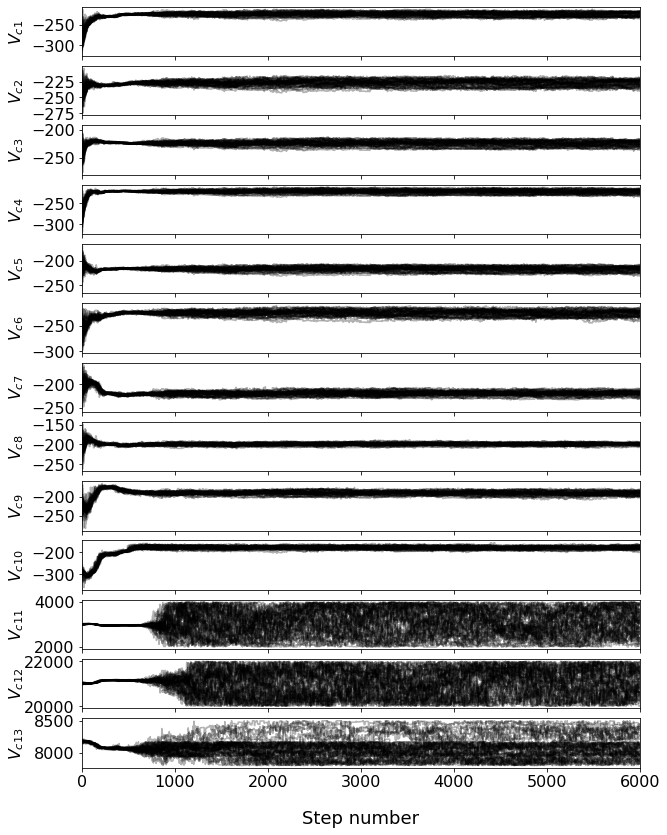

In [7]:
plot_walkers(samplers[0], 0)

R, v_c, sig-, sig+
6.98 224.2 6.4 4.8
8.93 226.6 6.5 4.8
10.88 224.3 5.6 4.5
12.82 222.5 5.4 4.5
14.78 216.7 6.1 4.5
16.73 224.7 7.2 5.5
18.68 219.5 5.0 4.8
20.62 199.1 3.5 3.2
22.58 190.7 5.6 5.2
24.52 179.5 7.5 7.4
[[-224.24409824    6.41307217    4.78554229]
 [-226.6218472     6.48494816    4.81475503]
 [-224.27322929    5.64328455    4.54186103]
 [-222.50170877    5.35373075    4.48392182]
 [-216.71790999    6.05506998    4.52987632]
 [-224.69822674    7.19496465    5.5299867 ]
 [-219.51907186    5.02828428    4.7567501 ]
 [-199.13056646    3.47766461    3.18853861]
 [-190.72563795    5.57533176    5.15681849]
 [-179.49141438    7.48874054    7.37207677]]
[-224.24409824 -226.6218472  -224.27322929 -222.50170877 -216.71790999
 -224.69822674 -219.51907186 -199.13056646 -190.72563795 -179.49141438]
LinregressResult(slope=-0.002426506690160001, intercept=251.00985145760907, rvalue=-0.8538647035091955, pvalue=0.0016662230457853897, stderr=0.0005229546375105359)
(10,)
(10,)
R, v_c, sig-,

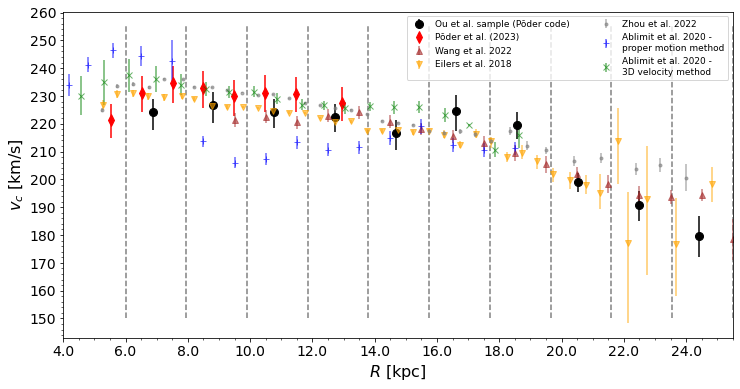

In [40]:
# Ou et al. sample (Poder code ) VS Poder et al. (2023)

extra_dims = [3, 3]
result_name_1 = 'Ou et al. sample (Põder code)'
result_name_2 = 'Põder et al. (2023)'

plot_rotation_curve([paths[0], paths[1]], 
                    [result_name_1, result_name_2],
                    [2000, 2000],
                    extra_dims=extra_dims,
                    display_eilers=True, 
                    display_bin_edges=True)

plt.savefig("Poder_VS_Ou_sample_our_code.pdf", format='pdf', dpi=300, bbox_inches='tight')

## Figure 2: Ou et al. vs Ou et al. sample (Poder code)

In [97]:
# Curves from literature

headers = ['R', 'v_c', 'sig']
cepheids_pm_method = pd.read_csv("../others_curves/cepheids_ablimit_1.dat", sep='  ', names=headers, skiprows=2, engine='python')
cepheids_vel_method = pd.read_csv("../others_curves/cepheids_ablimit_2.dat", sep='  ', names=headers, skiprows=2,  engine='python')
vc_data_wang = pd.read_csv("../others_curves/vcdata_wang+2022.dat", sep='  ', names=headers, skiprows=3, engine='python')
vc_zhou = pd.read_csv("../others_curves/vc_zhou_etal.csv", sep=' ', names=headers, skiprows=0, index_col=False, engine='python')

headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("../others_curves/Eilers_RC_Data.csv", sep=' ', names=headers)
ou_rc = pd.read_csv("/home/sven/repos/gaia-tools/jupyter-notebook/others_curves/vc_Ou.csv", sep=',')

other_curves_dict = {'Ou et al. 2023': ou_rc}

/home/sven/repos/dspn/dspn_env/lib64/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/sven/repos/dspn/dspn_env/lib64/python3.6/site-packages/ipykernel_launcher.py:167: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


R, v_c, sig-, sig+
6.98 224.2 6.4 4.8
8.93 226.6 6.5 4.8
10.88 224.3 5.6 4.5
12.82 222.5 5.4 4.5
14.78 216.7 6.1 4.5
16.73 224.7 7.2 5.5
18.68 219.5 5.0 4.8
20.62 199.1 3.5 3.2
22.58 190.7 5.6 5.2
24.52 179.5 7.5 7.4
[[-224.24409824    6.41307217    4.78554229]
 [-226.6218472     6.48494816    4.81475503]
 [-224.27322929    5.64328455    4.54186103]
 [-222.50170877    5.35373075    4.48392182]
 [-216.71790999    6.05506998    4.52987632]
 [-224.69822674    7.19496465    5.5299867 ]
 [-219.51907186    5.02828428    4.7567501 ]
 [-199.13056646    3.47766461    3.18853861]
 [-190.72563795    5.57533176    5.15681849]
 [-179.49141438    7.48874054    7.37207677]]
[-224.24409824 -226.6218472  -224.27322929 -222.50170877 -216.71790999
 -224.69822674 -219.51907186 -199.13056646 -190.72563795 -179.49141438]
LinregressResult(slope=-0.002426506690160001, intercept=251.00985145760907, rvalue=-0.8538647035091955, pvalue=0.0016662230457853897, stderr=0.0005229546375105359)
(10,)
(10,)
Ou et al. 202

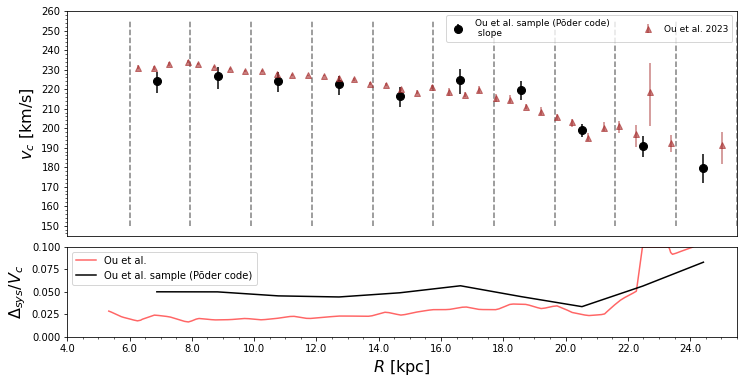

In [98]:
# Ou et al. VS Ou et al. sample (Poder code )

extra_dims = [3]
result_name_1 = 'Ou et al. sample (Põder code) \n slope'
slope=-0.002426506690160001

x, y =plot_rotation_curve_delta_unc([paths[0]], 
                    [result_name_1],
                    [2000],
                    extra_dims=extra_dims,
                    display_eilers=True, 
                    display_bin_edges=True)
plt.savefig("Ou_VS_Ou_sample_our_code.pdf", format='pdf', dpi=300, bbox_inches='tight')

## Corner plot for Ou et al. sample

In [57]:
from _corner import corner
from scipy.stats import gaussian_kde

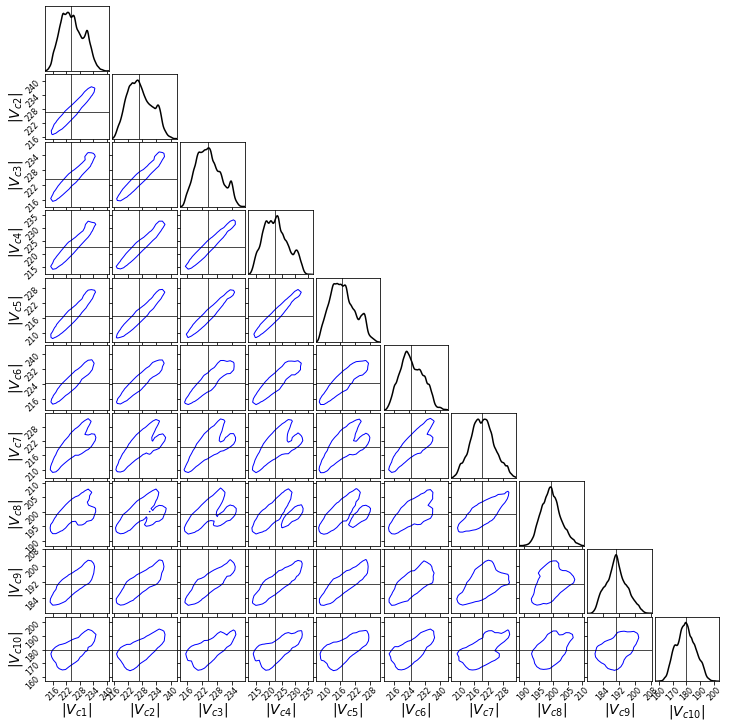

In [61]:
xdf = np.arange(0,10,1)
theta_labels = [r'$|V_{c%s}|$' %str(i+1) for i in xdf]

burn_in = 2000
path = samplers[0]
reader = emcee.backends.HDFBackend(path, read_only=True)
flatchain = reader.get_chain(flat=True, discard = burn_in)
flatchain = flatchain[:, 0:10]
flatchain=np.abs(flatchain)
v_med = np.median(flatchain, 0)

fig, axes =corner(flatchain, plot_datapoints = False,  
                  title_kwargs={"fontsize": 15},
                  levels=(0, 1-np.exp(-2)), 
                   labels=theta_labels,
                    plot_density = False, 
                    fill_countours = False,
                    smooth = 0.5, 
                    color='blue')





from scipy.stats import gaussian_kde

# plot KDE smoothed version of 1D marginalised distributions

for axidx, samps in zip(np.arange(0, 10*10, 11), flatchain.T):

    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim(); 

    xvals = np.linspace(xvals[0], xvals[1], 100)
    yvals =  kde(xvals)
    fig.axes[axidx].plot(xvals, yvals/np.max(yvals), color="black", lw=1.5) 
    
    # the division by np.max(kde(xvals)) is what normalises the 1D curves
y_label_idx = np.arange(10, 101, 10)
x_label_idx = np.arange(90, 100, 1)
for i, ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', labelsize=8)

    if(i in y_label_idx):
        ax.set_ylabel(theta_labels[int(i/10)], fontsize=14, labelpad=20)
        ax.tick_params(axis='both', labelsize=8, pad=0)
    if(i in x_label_idx):
        ax.tick_params(axis='both', labelsize=8, pad=0)
        ax.set_xlabel(theta_labels[i%90], fontsize=14, labelpad=10)

    if(i==99):
        ax.set_xlabel(theta_labels[i%90], fontsize=14, labelpad=0)

ndim = 10

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(v_med[i], color="black", lw=0.7)

for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(v_med[xi], color="black", lw=0.7)
        ax.axhline(v_med[yi], color="black", lw=0.7)
        ax.plot(v_med[xi], v_med[yi], "black")


#plt.savefig("corner_all_runs.pdf", format='pdf', dpi=300, bbox_inches='tight')



(192000, 13)


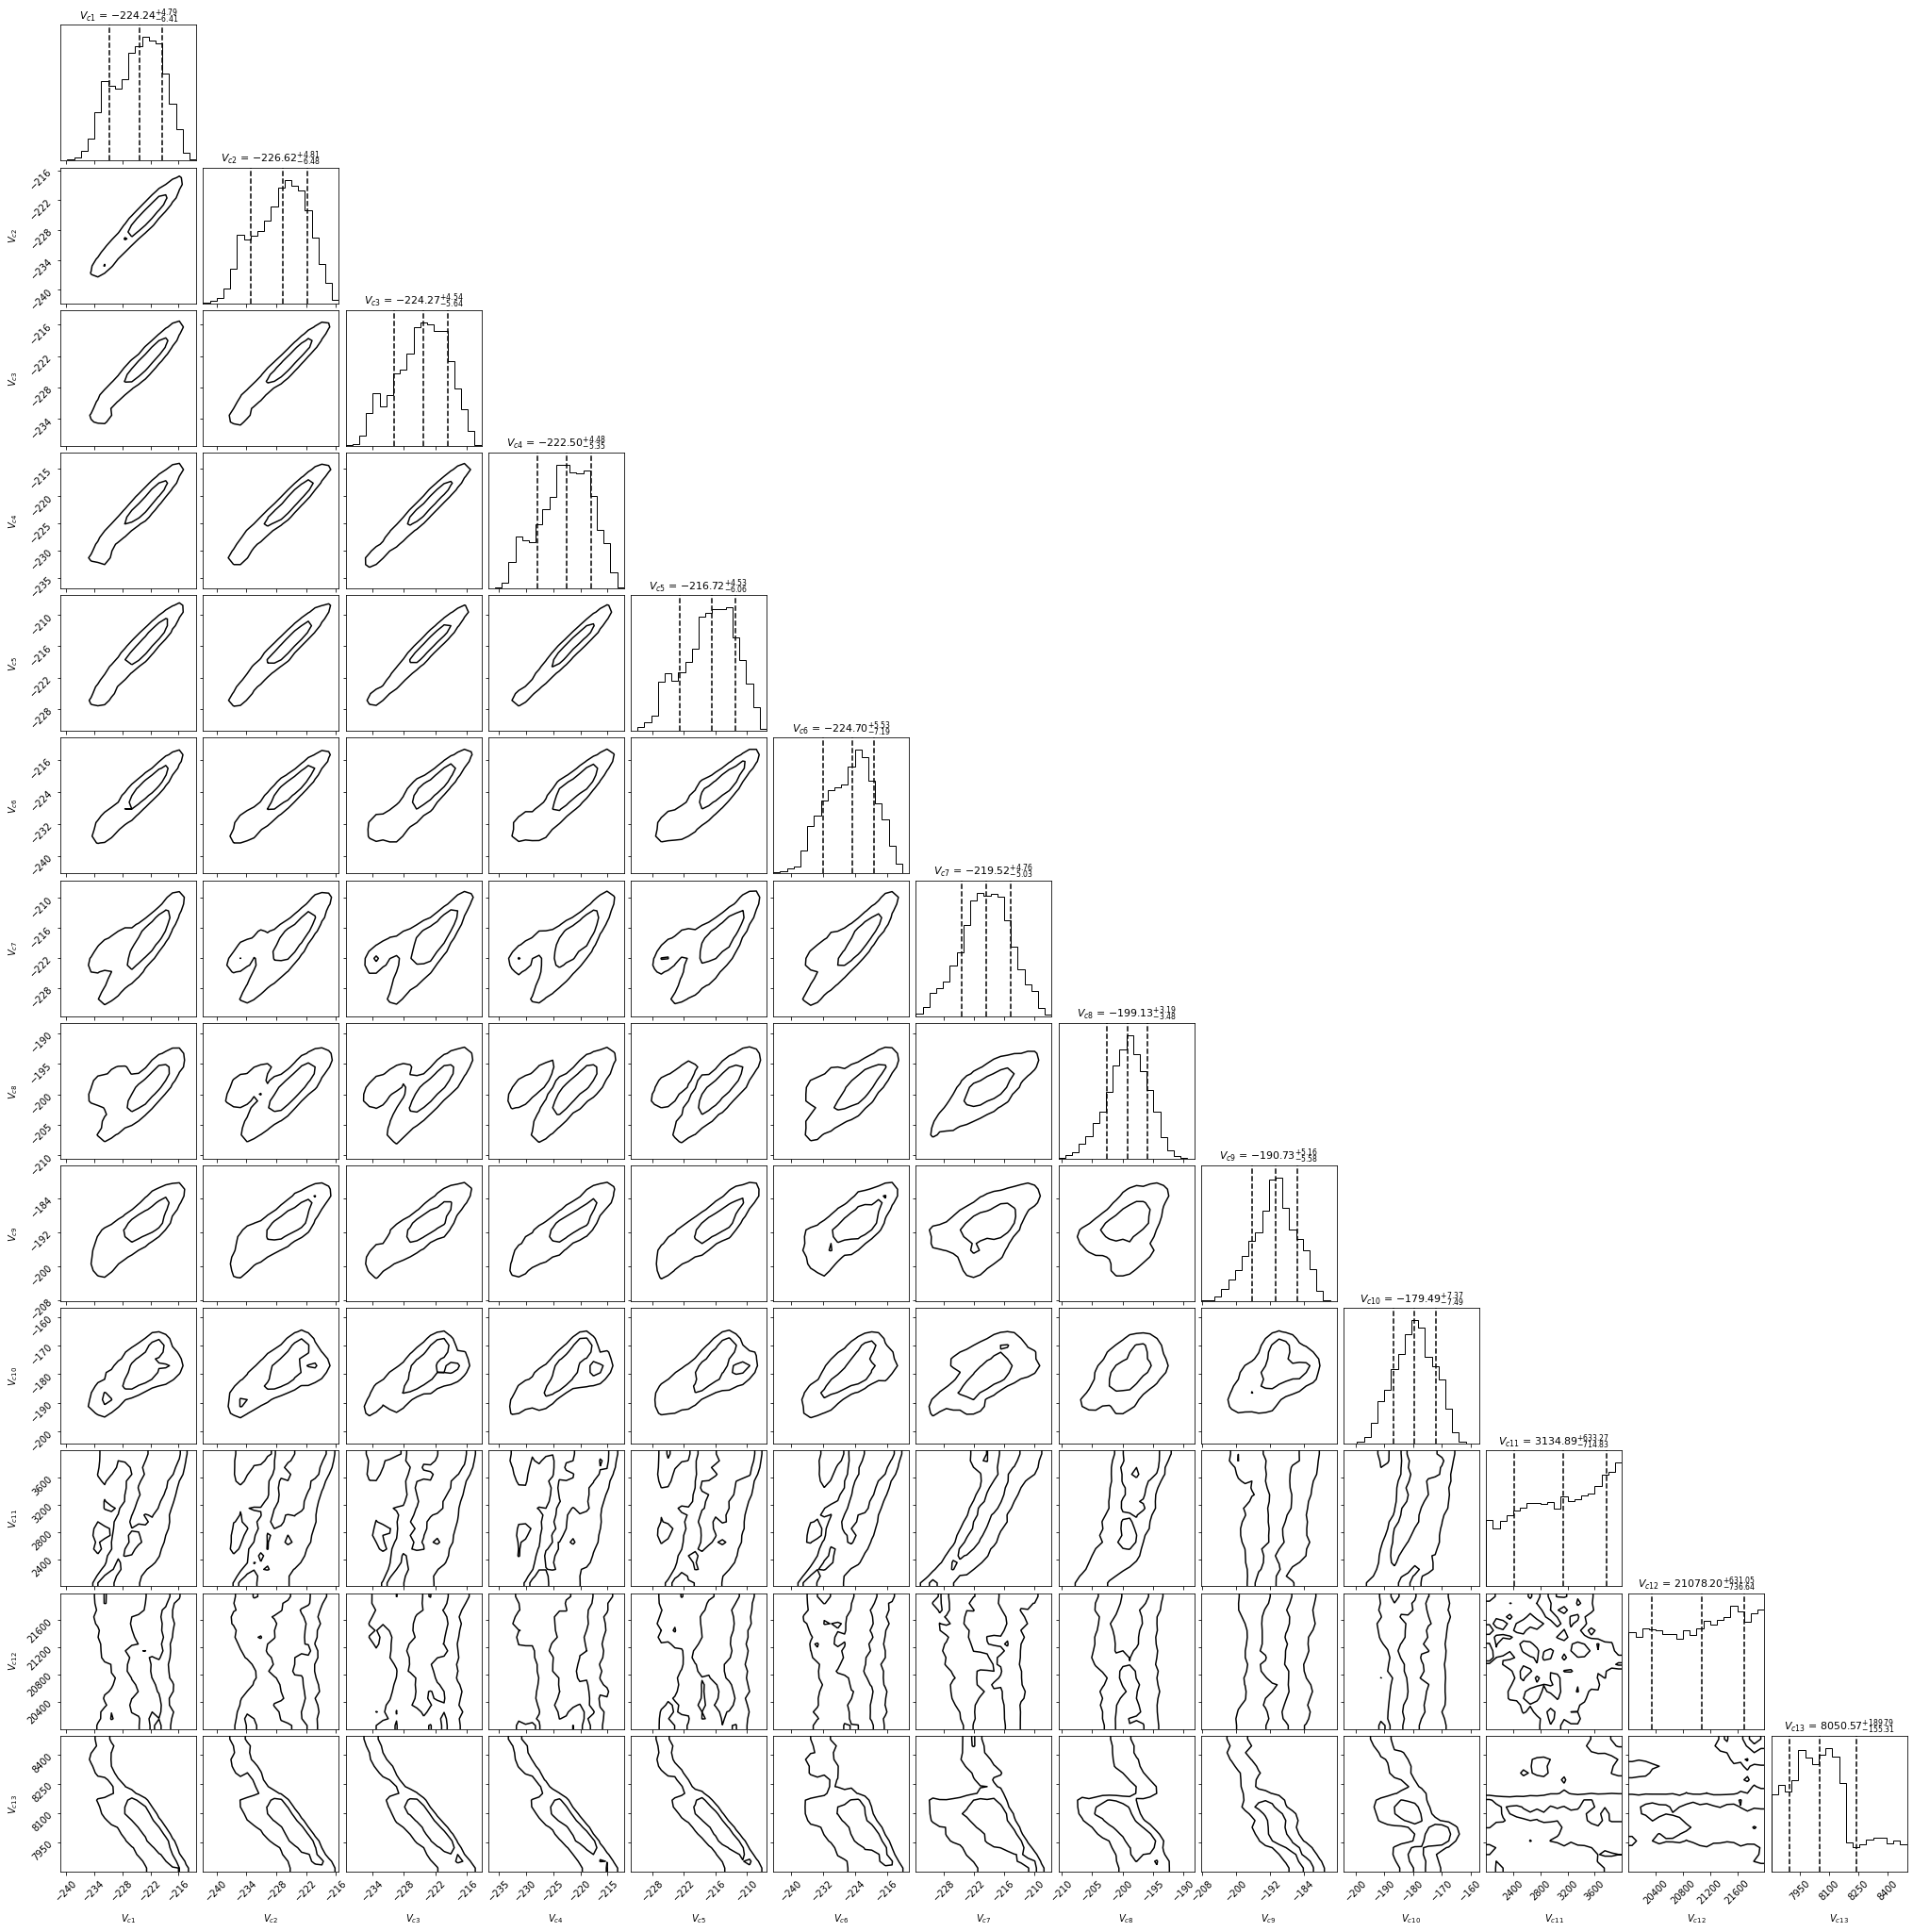

In [62]:
plot_corner(samplers[0], burn_in = 2000)

## Relative uncertainty plot

In [7]:
Ou_unc_data_path = '/home/sven/repos/gaia-tools/jupyter-notebook/xo_data_nbs/uncertainties_Ou.dat'
Ou_unc_data = pd.read_csv(Ou_unc_data_path, skiprows=2, names=['R', 'Delta'], delimiter='    ')

/home/sven/repos/dspn/dspn_env/lib64/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [9]:
deta_Ou_sample = (y[:, 1] + y[:, 2])/np.abs(y[:,0])
deta_Ou_sample.shape

(10,)

In [99]:
Ou_unc_data.R

0       5.331956
1       5.415464
2       5.478638
3       5.541813
4       5.604987
         ...    
204    23.782618
205    23.856713
206    23.931836
207    23.995010
208    24.080295
Name: R, Length: 209, dtype: float64

(0.0, 0.1)

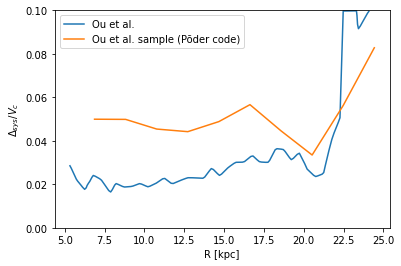

In [11]:
x_ou = Ou_unc_data.R
y_ou = Ou_unc_data.Delta
plt.plot(x_ou, y_ou, label='Ou et al.')
plt.plot(x/1e3, deta_Ou_sample, label='Ou et al. sample (Põder code)')
plt.xlabel('R [kpc]')
plt.ylabel(r'$\Delta_{sys}/V_c$')
plt.legend()
plt.ylim(0, 0.1)


## Small Prior Test

In [89]:
# Curves from literature

headers = ['R', 'v_c', 'sig']
cepheids_pm_method = pd.read_csv("../others_curves/cepheids_ablimit_1.dat", sep='  ', names=headers, skiprows=2, engine='python')
cepheids_vel_method = pd.read_csv("../others_curves/cepheids_ablimit_2.dat", sep='  ', names=headers, skiprows=2,  engine='python')
vc_data_wang = pd.read_csv("../others_curves/vcdata_wang+2022.dat", sep='  ', names=headers, skiprows=3, engine='python')
vc_zhou = pd.read_csv("../others_curves/vc_zhou_etal.csv", sep=' ', names=headers, skiprows=0, index_col=False, engine='python')

headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("../others_curves/Eilers_RC_Data.csv", sep=' ', names=headers)
ou_rc = pd.read_csv("/home/sven/repos/gaia-tools/jupyter-notebook/others_curves/vc_Ou.csv", sep=',')

other_curves_dict = {'Ou et al. 2023': ou_rc}

In [90]:

path1 = '/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-01-05-14-11-54_48_OU_run'
path2 = '/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-01-08-16-02-54_48_OU_run_small_R0_prior'
paths=[path1, path2]
labels =[]

samplers=[]
for folder_path in paths:
    sampler_path = folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5'
    samplers.append(sampler_path)
    print(sampler_path)

# Load run settings and print
bin_setup = load_bin_settings(path2, True)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-01-05-14-11-54_48_OU_run/sampler_2024-01-05-14-11-54.h5
/home/sven/repos/gaia-tools/out/mcmc_runs_OU/2024-01-08-16-02-54_48_OU_run_small_R0_prior/sampler_2024-01-08-16-02-54.h5
1. bin_centers_r= [ 6975.  8925. 10875. 12825. 14775. 16725. 18675. 20625. 22575. 24525.]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 6000.,  7950.,  9900., 11850., 13800., 15750., 17700., 19650.,
        21600., 23550., 25500.],
       [ 6000.,  7950.,  9900., 11850., 13800., 15750., 17700., 19650.,
        21600., 23550., 25500.]]), array([[-1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
        -1000., -1000., -1000.],
       [ 1000.,  1000.,  1000.,  1000.,  1000.,  1000.,  1000.,  1000.,
         1000.,  1000.,  1000.]]))
4. nbins= 10
5. V_sun= [[  5.1]
 [247.3]
 [  7.8]]
6. R_0= 8178
7. Z_0= 20.8
8. final_sample_size= (33919, 14)
9. disk_scale= 3000.0
10. vlos_dispersion_scale= 21000.0
11. A_r_info= [(6975.0, 30

Sampler shape: (6000, 48, 13)


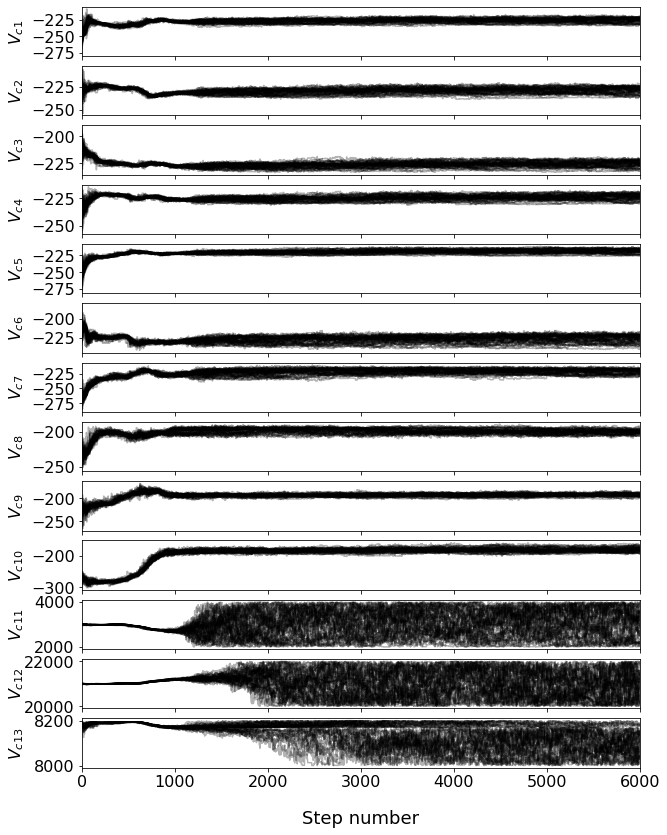

In [86]:
plot_walkers(samplers[1], 0)

R, v_c, sig-, sig+
6.98 224.2 6.4 4.8
8.93 226.6 6.5 4.8
10.88 224.3 5.6 4.5
12.82 222.5 5.4 4.5
14.78 216.7 6.1 4.5
16.73 224.7 7.2 5.5
18.68 219.5 5.0 4.8
20.62 199.1 3.5 3.2
22.58 190.7 5.6 5.2
24.52 179.5 7.5 7.4
[[-224.24409824    6.41307217    4.78554229]
 [-226.6218472     6.48494816    4.81475503]
 [-224.27322929    5.64328455    4.54186103]
 [-222.50170877    5.35373075    4.48392182]
 [-216.71790999    6.05506998    4.52987632]
 [-224.69822674    7.19496465    5.5299867 ]
 [-219.51907186    5.02828428    4.7567501 ]
 [-199.13056646    3.47766461    3.18853861]
 [-190.72563795    5.57533176    5.15681849]
 [-179.49141438    7.48874054    7.37207677]]
[-224.24409824 -226.6218472  -224.27322929 -222.50170877 -216.71790999
 -224.69822674 -219.51907186 -199.13056646 -190.72563795 -179.49141438]
LinregressResult(slope=-0.002426506690160001, intercept=251.00985145760907, rvalue=-0.8538647035091955, pvalue=0.0016662230457853897, stderr=0.0005229546375105359)
(10,)
(10,)
R, v_c, sig-,

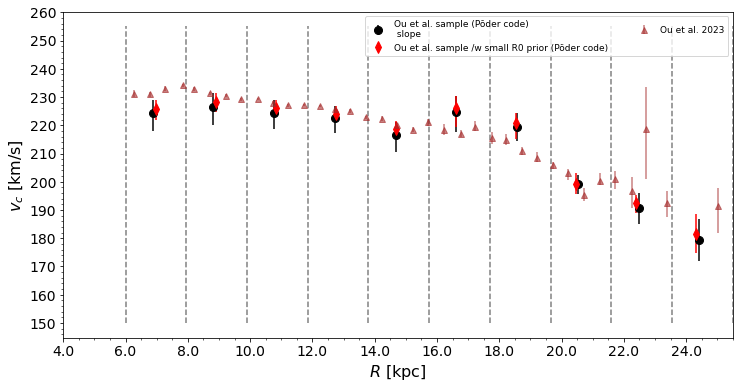

In [93]:
# Ou et al. VS Ou et al. sample (Poder code )

extra_dims = [3, 3]
result_name_1 = 'Ou et al. sample (Põder code) \n slope'
result_name_2 = 'Ou et al. sample /w small R0 prior (Põder code)'
slope=-0.002426506690160001

x, y = plot_rotation_curve([paths[0], paths[1]], 
                    [result_name_1, result_name_2],
                    [2000, 3000],
                    extra_dims=extra_dims,
                    display_eilers=True, 
                    display_bin_edges=True)
#plt.savefig("Ou_VS_Ou_sample_our_code.pdf", format='pdf', dpi=300, bbox_inches='tight')

/home/sven/repos/dspn/dspn_env/lib64/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/sven/repos/dspn/dspn_env/lib64/python3.6/site-packages/ipykernel_launcher.py:167: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


R, v_c, sig-, sig+
6.98 225.9 3.9 3.1
8.93 228.4 3.8 3.1
10.88 226.0 2.9 2.8
12.82 224.1 2.7 2.7
14.78 218.6 3.1 3.1
16.73 226.1 6.6 4.2
18.68 220.7 5.4 3.9
20.62 199.3 3.7 3.9
22.58 192.4 3.4 3.1
24.52 181.6 6.6 7.0
[[-225.90570514    3.94010386    3.12221006]
 [-228.36049881    3.82209209    3.12845698]
 [-226.00896919    2.8542613     2.81436505]
 [-224.12897552    2.66933639    2.67083704]
 [-218.62916154    3.0526495     3.05403691]
 [-226.05918011    6.56604651    4.24205328]
 [-220.67283293    5.39691621    3.85955245]
 [-199.29143366    3.69427082    3.8662554 ]
 [-192.35541995    3.39948069    3.13555363]
 [-181.58542138    6.62940904    6.98860743]]
[-225.90570514 -228.36049881 -226.00896919 -224.12897552 -218.62916154
 -226.05918011 -220.67283293 -199.29143366 -192.35541995 -181.58542138]
LinregressResult(slope=-0.002447378998377439, intercept=252.84597904742805, rvalue=-0.8599591666403703, pvalue=0.0014160616786189745, stderr=0.0005135201073239008)
(10,)
(10,)
Ou et al. 202

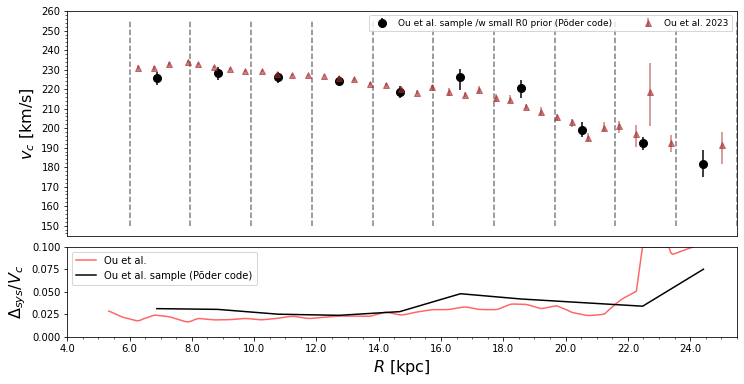

In [92]:
# Ou et al. VS Ou et al. sample (Poder code )

extra_dims = [3]
result_name_1 = 'Ou et al. sample /w small R0 prior (Põder code)'
slope=-0.002426506690160001

x, y =plot_rotation_curve_delta_unc([paths[1]], 
                    [result_name_1],
                    [3000],
                    extra_dims=extra_dims,
                    display_eilers=True, 
                    display_bin_edges=True)
#plt.savefig("Ou_VS_Ou_sample_our_code.pdf", format='pdf', dpi=300, bbox_inches='tight')

## Data out

Ou sample Vc to CSV

In [53]:
import pandas as pd

# Provided data
data = {
    "R": x,
    "v_c": y[:,0],
    "sig_below": y[:,1],
    "sig_above": y[:,2]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Saving to CSV
csv_file = 'vc_Ou_sample_Poder_code.csv'
df.to_csv(csv_file, index=False)

Ou data to CSV

In [59]:
import pandas as pd

# Provided data
data = {
    "R": [6.27, 6.78, 7.28, 7.86, 8.19, 8.71, 9.23, 9.72, 10.24, 10.74, 11.23, 11.73, 12.23, 12.73, 13.22, 13.72, 14.22,
          14.73, 15.24, 15.72, 16.24, 16.77, 17.21, 17.77, 18.23, 18.73, 19.22, 19.71, 20.22, 20.72, 21.22, 21.72, 22.27,
          22.71, 23.40, 25.02, 27.31],
    "v_c": [231.07, 230.93, 232.87, 234.14, 232.83, 231.27, 230.47, 229.16, 229.37, 227.95, 227.09, 227.15, 226.90, 225.61,
            224.95, 222.79, 222.13, 220.08, 218.25, 221.16, 218.30, 217.07, 219.56, 215.49, 214.62, 210.89, 208.48, 205.97,
            202.97, 195.16, 200.20, 201.11, 196.79, 218.65, 192.49, 191.48, 172.98],
    "sig_above": [1.28, 0.97, 1.13, 0.63, 0.56, 0.54, 0.44, 0.54, 0.25, 0.53, 0.44, 0.35, 0.39, 0.64, 0.66, 0.68, 1.04, 
                  0.65, 1.14, 1.06, 2.17, 1.39, 1.80, 1.98, 2.24, 1.42, 2.20, 1.20, 1.55, 2.60, 2.84, 2.72, 4.82, 14.93, 
                  4.25, 6.41, 15.82],
    "sig_below": [1.00, 0.97, 0.79, 0.62, 0.55, 0.66, 0.46, 0.43, 0.50, 0.34, 0.46, 0.45, 0.41, 0.53, 0.69, 0.53, 0.64, 
                  0.89, 0.79, 1.24, 1.88, 1.35, 1.69, 2.08, 1.59, 1.32, 1.65, 1.55, 2.25, 1.97, 1.45, 3.81, 6.25, 17.54, 
                  4.80, 9.61, 17.07],
    "N": [764, 676, 812, 1631, 2270, 1445, 2179, 2505, 2560, 2528, 2692, 2419, 2285, 1994, 1665, 1308, 938, 641, 449, 322,
          243, 164, 150, 114, 102, 94, 71, 70, 65, 46, 38, 30, 14, 11, 22, 11, 7]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Saving to CSV
csv_file = '/home/sven/repos/gaia-tools/jupyter-notebook/others_curves/vc_Ou.csv'
df.to_csv(csv_file, index=False)